In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from scipy import sparse

## Lazy random walk

In [ ]:
def create_transition_matrix(n):
    """
    Create transition matrix of each
    graph: Ring, Binary tree and 2D grid
    like torus. Performing a Lazy Random
    Walk over each graph.

    Parameters
    ----------
    n : int
        Number of vertices of each graph
        preferred to be a power of 2

    Returns
    -------
    P_graphs: dict
        Return a dictionary containing
        the ring graph, binary tree graph
        and 2D grid torus like graph
        probabilities
    
    pi_graphs: dict
        Return a stationary distribution
        of each graph based on the analytic
        solution \pi_i= d_i/2m where d_i is the
        degree of vertice i
    """
    P_graphs = {}
    pi_graphs = {}
    # Graph ring
    P = np.zeros((n,n),dtype=np.float64)
    pi = np.zeros((n), dtype=np.float64)
    # number of vertex = number of edges on ring
    m = n
    di = 2
    for i in range(n):
        P[i,i] = 1/2
        P[i,(i+1)%n] = 1/4
        P[i,i-1] = 1/4
        pi[i] = di/(2*m)
    P_graphs['ring'] = P
    pi_graphs['ring'] = pi
    
    # 127 vertices on Complete Binary Tree graph
    level = int(np.log2(n))
    # 2 times the number of vertices besides leafs
    m = 2*(2**(level-1)-1)
    P = np.zeros((n-1,n-1))
    pi = np.zeros((n-1))
    for l in range(level):
        number_start_leaf = (2**(level-1))-1
        for i in range(2**l):
            vertex = 2**l + i - 1
            vertex_less = 2**(l+1) + 2*i - 1
            vertex_more = 2**(l+1) + 2*i 
            vertex_previous = int(2**(l-1) + i/2) -1

            P[vertex, vertex] = 1/2

            if (vertex > 0) and (vertex < number_start_leaf):
                di = 3
                P[vertex, vertex_less] = 1/6
                P[vertex, vertex_more] = 1/6
                P[vertex, vertex_previous] = 1/6

            if vertex == 0:
                di = 2
                P[vertex, vertex_less] = 1/4
                P[vertex, vertex_more] = 1/4

            if vertex >= number_start_leaf:
                di = 1
                P[vertex, vertex_previous] = 1/2

            pi[vertex] = di/(2*m)

    P_graphs['tree'] = P
    pi_graphs['tree'] = pi

    # 2D grid as Torus
    size = int(np.ceil(np.sqrt(n)))
    vertices = size**2
    P = np.zeros((vertices,vertices))
    pi = np.zeros((vertices))
    # 2 times the number of vertices
    m = 2*vertices
    di = 4
    for i in range(vertices):
        row = int(i/size)
        vertex = i
        vertex_left = row*size+(i-1)%size
        vertex_right = row*size + (i+1)%size
        vertex_up = i-size
        vertex_down = (i+size)%vertices

        P[vertex, vertex] = 1/2
        P[vertex, vertex_left] = 1/8
        P[vertex, vertex_right] = 1/8
        P[vertex, vertex_up] = 1/8
        P[vertex, vertex_down] = 1/8
        pi[vertex] = di/(2*m)

    P_graphs['grid'] = P
    pi_graphs['grid'] = pi

    return P_graphs , pi_graphs

In [ ]:
def total_variation(vec_a, vec_b):
    """
    Calculate total variation distance

    Parameters
    ----------
    vec_a : ndarray
        Array alpha
    
    vec_b: ndarray
        Array betha

    Returns
    -------
    d_vt : float
        d_vt = 1/2 * \sum_k |alpha_k - betha_k| 
    """
    d_vt = np.sum(abs(vec_a-vec_b),dtype=np.float128)/2
    return d_vt

In [ ]:
def calculate_dvt_over_time(n, time):
    """
    Calculate total variation 
    over time for each graph
    created on previously
    functions.

    Parameters
    ----------
    n : int
        Number of vertices of 
        each graph, preferred 
        to be a power of 2.

    time: int
        Max time of d_vt analysis

    Returns
    -------
    dvt_graph: dict
        Return dvt for each
        interval of 10 points of t
        of each graph on a dict

    t : list
        Invervals of time used
    """
    P_graph, pi_graphs = create_transition_matrix(n)
    max_time = time
    t = np.arange(1, max_time,10)
    dvt_graph = {}
    for graph in P_graph:
        P = P_graph[graph]
        pi = pi_graphs[graph]
        pi_zero = np.zeros_like(pi)
        pi_zero[0] = 1
        dvt_list = []
        for i in range(max_time):
            pi_zero = pi_zero.dot(P)
            if i in t:
                dvt = total_variation(pi, pi_zero)
                dvt_list.append(dvt)

        dvt_graph[graph] = dvt_list
    return dvt_graph , t

In [ ]:
def calculate_mixing_time(n_list, epsilon):
    """
    Calculate mixing time for each graph
    described previously 

    Parameters
    ----------
    n_list : list
        List with each number of 
        vertices.
    
    epsilon : float
        Threshold for stopping mixing 
        time.

    Returns
    -------
    t_graph : dict
        Return mixing time for each
        graph related of each number
        of vertices on n_list
    """
    t_graph = {}
    for n in tqdm(n_list):
        P_graph, pi_graphs = create_transition_matrix(n)
        for graph in P_graph:
            if graph not in t_graph:
                t_graph[graph] = []
            P = P_graph[graph]
            # Create a sparse matrix to handle ring graph
            sP = sparse.csr_matrix(P)
            pi = pi_graphs[graph]
            pi_zero = np.zeros_like(pi)
            pi_zero[0] = 1
            t_list = []
            dvt = 1
            t = 0 
            while dvt > epsilon:
                # Change pi_zero (pi(t)) to sparse
                # to be able to perform sparse 
                # matrix multiplication
                pi_zero = sparse.csr_matrix(pi_zero)
                pi_zero = pi_zero.dot(sP).toarray()
                dvt = total_variation(pi, pi_zero)
                t+=1
            t_graph[graph].append(t)

    return t_graph

In [ ]:
def calculate_spectral_gap(n_list):
    """
    Calculate spectral gap over
    each graph defined

    Parameters
    ----------
    n_list : list
        List of each value
        of vertices n
    Returns
    -------
    spectal_gap_graph : dict
        Return a dict with each
        spectral gap related with
        each graph and each n
    """
    spectral_gap_graph = {}
    for n in n_list:
        P_graph, pi_graphs = create_transition_matrix(n)
        for graph in P_graph:
            if graph not in spectral_gap_graph:
                spectral_gap_graph[graph] = []
            values = np.linalg.eigvals(P_graph[graph])
            values_set = set(np.real(values)) 
            values_set.remove(max(values_set)) 
            second_largest_eig_value = max(values_set)
            spectral_gap = 1 - second_largest_eig_value
            spectral_gap_graph[graph].append(spectral_gap)
    return spectral_gap_graph

In [ ]:
# Using n=128 instead of 100
dvt_graph, t = calculate_dvt_over_time(128, 10**3)

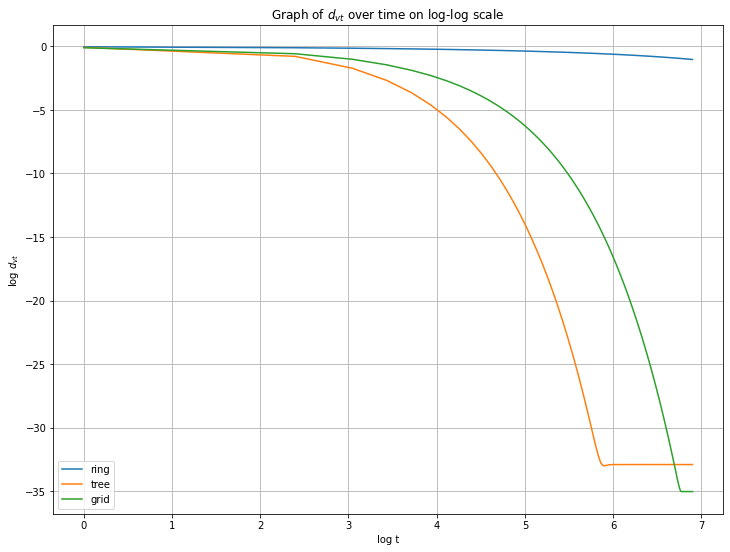

In [ ]:
plt.figure(figsize=(12,9))
plt.title("Graph of $d_{vt}$ over time on log-log scale")
plt.ylabel("log $d_{vt}$")
plt.xlabel("log t")
for graph in dvt_graph:
    plt.plot(np.log(t), np.log(dvt_graph[graph]), label=graph)
plt.grid()
plt.legend()
plt.show()

In [ ]:
# Due to full binary tree all n are in power of 2
n_list = [8,32,128,256,512,1024]
t_graph = calculate_mixing_time(n_list,1e-4)

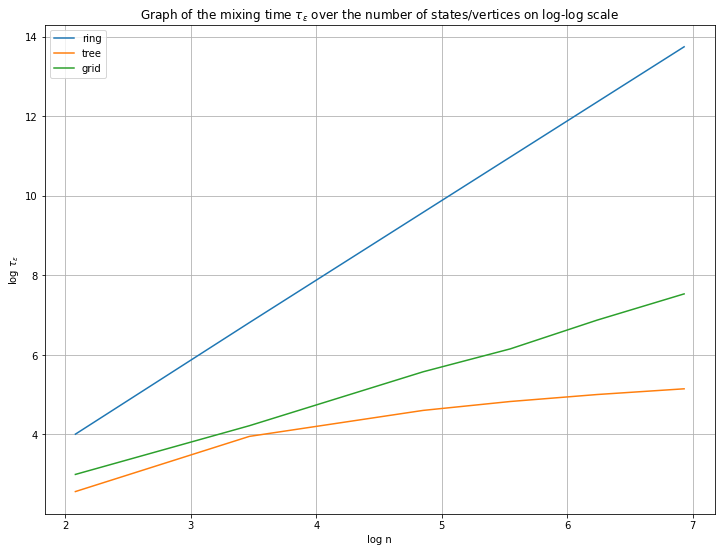

In [ ]:
plt.figure(figsize=(12,9))
plt.title("Graph of the mixing time $\\tau_{\\epsilon}$ over the number of states/vertices on log-log scale")
plt.ylabel("log $\\tau_{\\epsilon}$")
plt.xlabel("log n")
for graph in t_graph:
    plt.plot(np.log(n_list), np.log(t_graph[graph]), label=graph)
plt.grid()
plt.legend()
plt.show()

In [ ]:
spectral_gap_graph = calculate_spectral_gap(n_list)

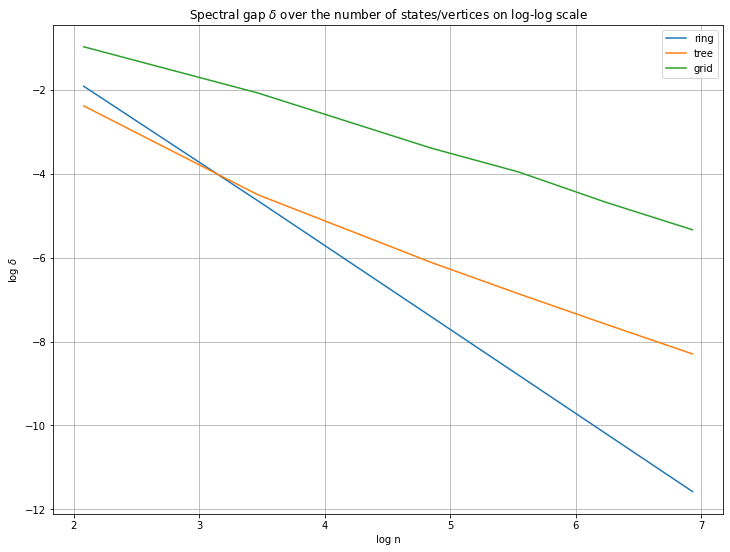

In [ ]:
plt.figure(figsize=(12,9))
plt.title("Spectral gap $\\delta$ over the number of states/vertices on log-log scale")
plt.ylabel("log $\\delta$")
plt.xlabel("log n")
for graph in t_graph:
    plt.plot(np.log(n_list), np.log(spectral_gap_graph[graph]), label=graph)
plt.grid()
plt.legend()
plt.show()